Роевая политика инкапсулирует то, какое общение происходит между агентами внутри роя. Ее можно определить через наследование от базового интерфейса ```Swarm``` с абстрактным методом ```get_action(swarm_state)```, который должен возвращать вектор действий для всех агентов внутри роя.

<img src="images/swarm_communication.jpg" width=600 height=150 />

Важно определять политику как можно более абстрактно, чтобы она не использовала особенности среды. Например, если политика делает математические преобразования над наблюдениями, а среда возвращает дискретные состояния, то такая политика не имеет смысла. В общем случае можно добавить преобразование, которое будет переводить произволные векторы в непрерывные.


Какие роевые политики можно задать из логических соображений?

1. ```SharePolicy```. Позволяет напрямую использовать политики других агентов. Например, можно отобрать несколько лучших агентов по ожидаемой награде в заданном состоянии, и среди них провести голосование за действие.
2. ```ShareObservations```. Некоторым образом агрегирует состояния агентов в единое, либо использует рекурентные модели для обработки последовательности состояний. Здесь еще есть идея создания иллюзий цели ```ObservationMirage```, которые бы помогали двигаться в сторону агентов с большим значением состояния, но пока придумал как реализовать это только в дискретной среде. Ну то есть формально движение не в каждой среде определено, например в непрерывной где у нас есть просто углы, в них нет смысла считать какие-то евклидовы расстояния. Экспериментально движение можно просимулировать, например, случайным поиском, и взять такую последовательность действий, применяя которые конечное состояние окажется наиболее близким к желаемому.
3. ```ShareParameters```. Заимствует части политик отдельных агентов, либо производит над ними какие-то преобразования. Но кажется с преобразованиями здесь не имеет смысла работать, потому что агенты могли видеть сильно разные состояния, а зависимость параметров от состояний нетривиальная, поэтому простыми математическими операциями здесь не обойтись. А вот отдельные слои можно попереставлять, главное чтобы эти слои были некоторой независимой частью всего процесса принятия решения, а не так, что давайте возьмем слой из середины в полносвязной сети. Здесь что-то похожее на ```FedMA```.

Сейчас я реализовал ```SharePolicy``` коммуникацию и более умную штуку ```IC3Net```[https://arxiv.org/pdf/1812.09755.pdf], в которую добавил несколько модификацией, которые задаются через флаги. Например, там есть ```communication_gate```, который решает прокидывать вектор с информацией дальше или нет, но иногда даже в реальной жизни часть информации можно просто утаить, то есть хочется сделать это небинарной штукой, мне показалось это полезным и к тому же это еще одна возможность для эксперимента.

### Немного рассуждений

Задача нелинейной аппроксимации с учетом смешнанной кооперативности в конкурирующей среде

Нам интересны структуры взаимодействий агентов и их влияние на динамику обучения. Также какой информацией обмениваемся  и как она влияет на состояния агентов / их удалённость от оптимума.

АГЕНТЫ В РОЕ ДОЛЖНЫ ИМЕТЬ ЕДИНУЮ ФУНКЦИЮ ПОТЕРЬ

Как скооперировать агентов чтобы получить лучший результат для популяции в целом? Или для группы? То есть, чтобы средняя индивидульная награда была как можно выше.

Как распределять награду внутри роя? Равномерно? Это в меньшей степени будет поощрять агентов которые внести больший вклад. Нормально в зависимости от усилий? Уже лучше подходит для реальной картины мира.

Как измерять вклад, которые агенты внесли в общую для роя награду? Например, количество сообщенной информации и ее полезность.

Как выбирать политики для агентов внутри роя? Могут ли они быть разными, и если да, то в каких случаях? Например для человечества да - сильный может объединиться со слабым просто потому что между ними есть дружба, для стаи птиц скорее нет, сложно представить себе что ястреб и воробей объединятся для совместного выживания, если это конечно не очередная экранизация дисней.
Люди и птицы изначально имеют разные классы моделей, которые в принципе не совместимы, например, одни способны думать рационально, другие нет.

Кооперация наблюдаемой информации может быть проведена, например, через сложение или максимизацию векторов наблюдений или опыта. Интуиция здесь такая: ты видишь, я слышу, а вместе мы делаем и то и другое. Расшаривание параметров модели больше похоже на какой-то биологический процесс пересадки органов. Могут существовать агенты с плохим восприятием на начальном этапе, может их не стоит учитывать, например взяв квантиль и выделяя касты внутри роя, то есть расмматривать более сложные структуры.

Мы получаем новые данные, и улучшаем нашу модель, подстраиваясь под изменяющуюся среду, которая не является детерминированной. Новое, это хорошо забытое старое, поэтому нельзя терять прежнее знание, если агенты существуют в рое, обязательно должны быть те, кто меньше исследует и больше просто хранит и применяет знания. Отсюда следует желание настраивать стремление к исследованию мира по разному для разных агентов.

Не факт что аппроксимация будет идеальная (вообще говоря она будет неидеальная всегда), если коммуникация не приводит к резутату можно взять наилучшую аппроксимацию отдельно взятого агента из роя с наибольшим весом.

Маловероятно получить идеальную аппроксимацию в принципе, потому что мир сильно непрерывен (например, в сложных средах да и в реальной жизни, далеко ходить не нужно). Кому-то повезло больше и он инициализировался поближе к теплому локальному оптимуму, кому-то меньше - и он родился на плоскогорье вдали от всяческих оптимумов. Но вот что, да, мы не можем влиять на состояние среды, но мы можем управлять нашей политикой, настраивая политику, взаимодействуя с другими агентами или даже объектами мы можем влиять на скорость нашей сходимости в какое-то хорошее место.

Есть предположение почему идеальный оптимум недостижим в приницпе. Поскольку модель этого мира описывается гиганстким количеством параметров, это будет многомерное пространство которое просто даже невозможно вообразить, в нем существует бесконечное число состояний, при рождении мы инициализируемся грубо говоря в рандомных местах, но в близких к тем, где человечество уже успело побывать. Чтобы совершить скачок нужно либо надеяться на удачу, что появится какой-то уникум в ранеее неизведанной локации и сообщит нам об этом посредством коммуникации, либо нужно своими силами расширять сети связи и общаться друг с другом, получая новую информацию, объединяя то что впринципе кажется несовместимым, и тогда появится возможность продвинуться вперед, но более равномерными и маленькими шажками - гиперпрыжок без удачи здесь невозможен, а удача здесь маловероятно при бесконечном количестве состояний.



### StateMirage

Пусть у нас есть рой, состоящий из агентов $a_1, a_2, \ldots a_n$. На вход поступают состояния $s_1, s_2, \ldots s_n$ для каждого агента соответственно. Используя политики агентов, посчитаем следующие ценности состояний $v_{\pi(a_1)}(s_1), v_{\pi(a_2)}(s_2), \ldots v_{\pi(a_n)}(s_n)$ и упорядочим их по убыванию. Тогда для каждого агента хотелось бы выбрать такое действие, которое приведет его в состояние лучше, чем то, в котором он находится сейчас.

### Оценка на среде ```PreadatorPrey```

In [1]:
from reinforcement.training import TrainingTask, TrainingConfig, PlayGround
from reinforcement.policy import PolicyFactory, SimpleFullyConnected

from reinforcement.communication.core import Agent
from reinforcement.communication import NoCommunication, SharePolicy, IC3NetBased
from reinforcement.communication.utils import generate_communication_matrix


from environments import PredatorPreyEnv
from environments.adapter import init_environment, EnvironmentMode
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pprint

config = TrainingConfig()
pprint.pprint(config)

TrainingConfig(seed=42,
               batch_size=32,
               epoch_count=40000,
               steps_per_epoch=1,
               learning_rate=0.0001,
               evaluation_frequency=100,
               games_per_evaluation=3,
               steps_per_evaluation=20,
               loss_frequency=20,
               update_target_frequency=100,
               experience_buffer_size=10000,
               init_explore_rate=1.0,
               final_explore_rate=0.1,
               decay_steps=10000)


In [3]:
config.steps_per_evaluation = 40

In [4]:
env = PredatorPreyEnv()
init_environment(env, dim=10, n_predators=10, mode=EnvironmentMode.Cooperative)

state_dim = np.prod(env.observation_space.shape)
n_actions = env.action_space.nvec.item()

factory = PolicyFactory(128, n_actions, hidden_size=64)

communication_matrix = generate_communication_matrix(10)

swarms = [
    IC3NetBased(
        squad=[Agent(index, factory.get_policy(SimpleFullyConnected)) for index in range(10)], 
        state_size=state_dim, hidden_size=128, communication_matrix=communication_matrix)
]
pg = PlayGround(env, swarms)

training_task = TrainingTask(pg, config)

In [5]:
training_task.run()

  0%|          | 0/40000 [02:05<?, ?it/s]

KeyboardInterrupt



In [7]:
report = training_task.get_report()

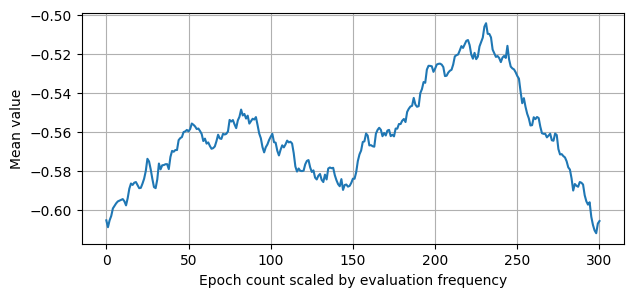

In [8]:
report.plot_common_report()

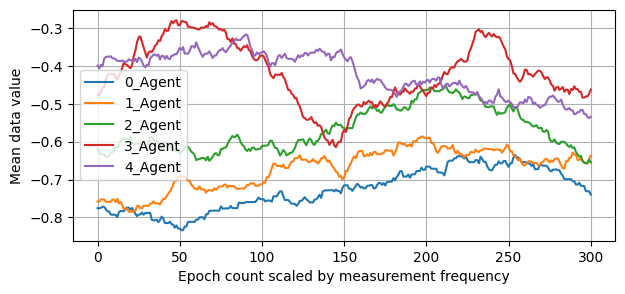

In [9]:
report.plot_for_each_agent()

In [11]:
factory = PolicyFactory(state_dim, n_actions, hidden_size = 64)

swarms = [
    SharePolicy([
        Agent(index, factory.get_policy(SimpleFullyConnected))
        for index in range(5)], best_neighbours=3)
]
pg = PlayGround(env, swarms)

training_task = TrainingTask(pg, config)

In [12]:
training_task.run()

100%|█████████████████████████████████████| 40000/40000 [29:19<00:00, 22.74it/s]


In [13]:
share_report = training_task.get_report()

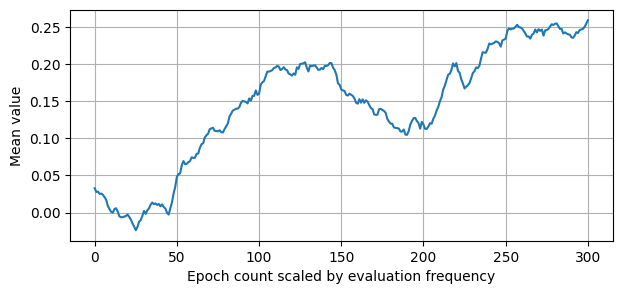

In [14]:
share_report.plot_common_report()

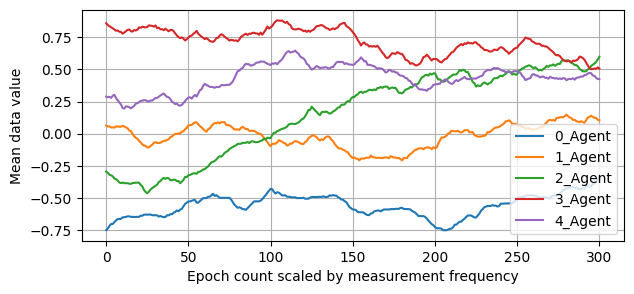

In [15]:
share_report.plot_for_each_agent()

In [17]:
factory = PolicyFactory(state_dim, n_actions, hidden_size = 64)

swarms = [
    NoCommunication([
        Agent(index, factory.get_policy(SimpleFullyConnected))
        for index in range(5)])
]
pg = PlayGround(env, swarms)

training_task = TrainingTask(pg, config)

In [18]:
training_task.run()

100%|█████████████████████████████████████| 40000/40000 [17:15<00:00, 38.63it/s]


In [19]:
no_report = training_task.get_report()

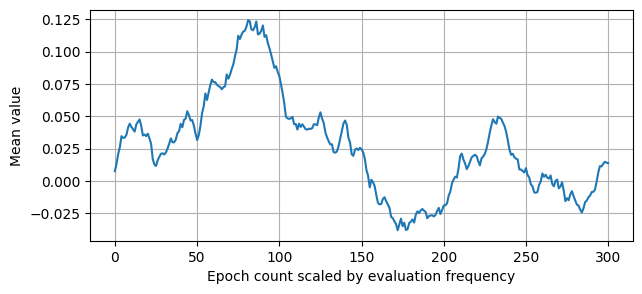

In [20]:
no_report.plot_common_report()

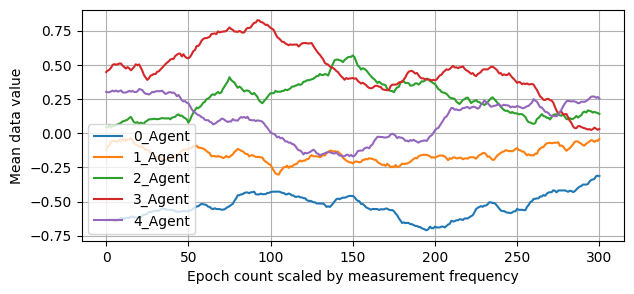

In [21]:
no_report.plot_for_each_agent()

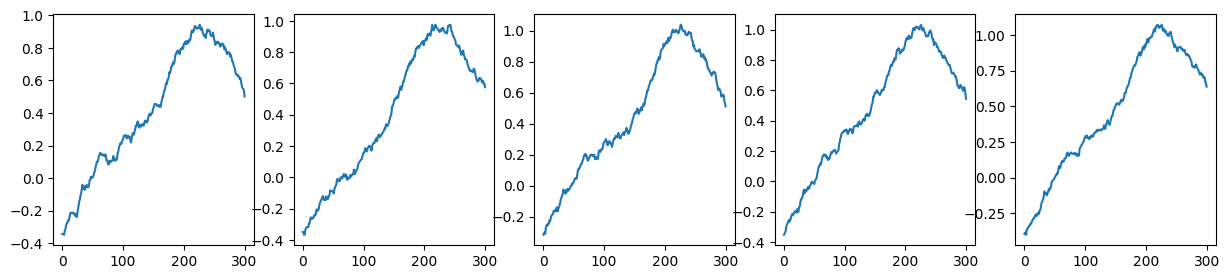

In [24]:
fig, ax = plt.subplots(1, 5, figsize = (15, 3))

for i in range(5):
    ax[i].plot(smooth(np.array(reward)[:,i]))

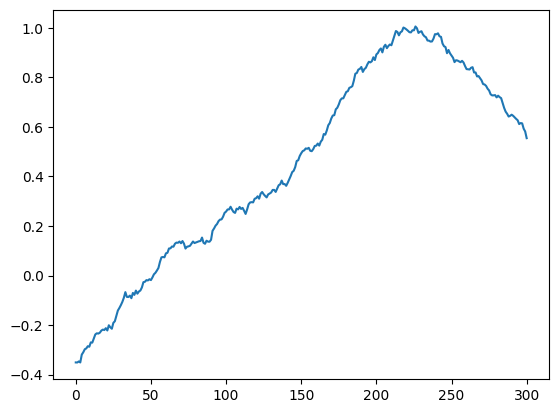

In [29]:
plt.plot(smooth(np.array(reward).mean(axis = 1)))

In [31]:
factory = PolicyFactory(128, n_actions, hidden_size = 64)

swarms = [
    IC3Net([
        Agent(index, factory.get_policy(SimpleFullyConnected)) 
        for index in range(5)],state_dim, hidden_size = 128)
]

pg = PlayGround(env, swarms)

ic3net_training_task = TrainingTask(pg, config)

In [33]:
ic3net_training_task.run()

100%|█████████████████████████████████████| 40000/40000 [49:01<00:00, 13.60it/s]


In [34]:
ic3net_report = ic3net_training_task.get_report()

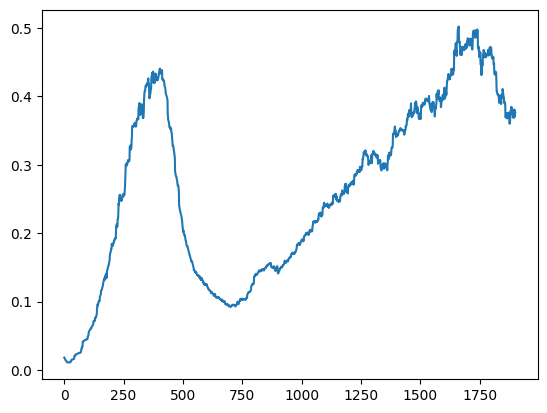

In [35]:
loss, reward = ic3net_report

plt.plot(smooth(np.array(loss).reshape(len(loss))))

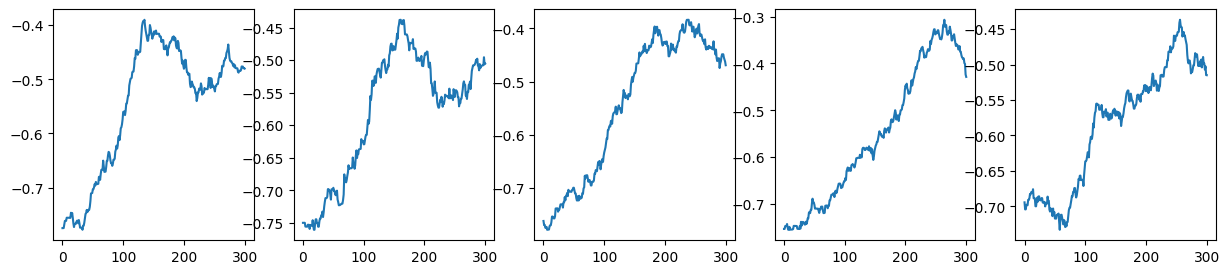

In [36]:
fig, ax = plt.subplots(1, 5, figsize = (15, 3))

for i in range(5):
    ax[i].plot(smooth(np.array(reward)[:,i]))

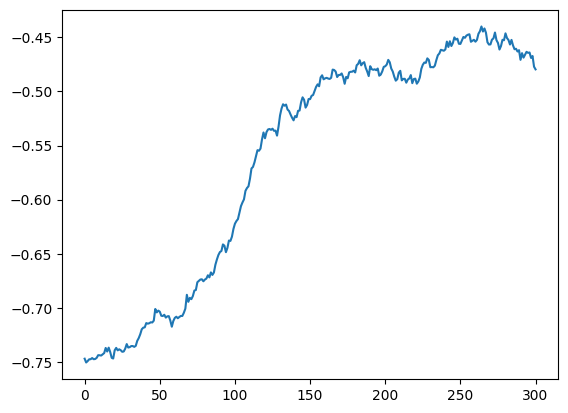

In [37]:
plt.plot(smooth(np.array(reward).mean(axis = 1)))

Видимо я что-то не так реализовал, либо взял мало эпох для обучения